In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input, Dropout
from sklearn.metrics import mean_absolute_error
from keras.optimizers import Adam
from matplotlib import pyplot as plt
from matplotlib import dates as mlp_dates
import seaborn as sns

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

In [2]:
%matplotlib inline

In [3]:
first_data = pd.read_csv('water_data.csv')

In [4]:
columns = ['Date', 'Drawdown', 'Rainfall', 'Water Level']  
first_data = first_data[columns]

In [5]:
first_data['Rainfall'] = pd.to_numeric(first_data['Rainfall'], errors='coerce')

# Split data into training and testing sets
train_size = int(len(first_data) * 0.8)
train_data = first_data.iloc[:train_size]
test_data = first_data.iloc[train_size:]

# Calculate means from training data
water_mean = train_data['Water Level'].mean()
drawdown_mean = train_data['Drawdown'].mean()

# Fill missing values with means
data = first_data.fillna(value={'Drawdown': drawdown_mean, 'Rainfall': 0, 'Water Level': water_mean,}).copy()

# Convert 'Date' column to datetime and set as index
data['Date'] = pd.to_datetime(data['Date'], format='%d-%b-%y')
data.set_index('Date', inplace=True)


In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

In [7]:
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :])
        y.append(data[i+seq_length, 0])
    return np.array(X), np.array(y)

seq_length = 7
X_train, y_train = create_sequences(scaled_data[:train_size], seq_length)
X_test, y_test = create_sequences(scaled_data[train_size:], seq_length)

In [8]:
# model architecture to output a single value
input_shape = X_train.shape[1:]
model = Sequential()
model.add(Input(shape=input_shape))
model.add(LSTM(units=64, activation='relu', return_sequences=True))
model.add(LSTM(units=32))
model.add(Dropout(0.5))
model.add(Dense(5, activation='relu'))  # Add a dense layer with 64 units and ReLU activation
model.add(Dense(1))

# Compile the LSTM model
adam = Adam(learning_rate=0.1)
model.compile( loss='mean_squared_error', optimizer='adam', metrics=['mae'])

In [9]:
%%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=5, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)
mcp = ModelCheckpoint(filepath='model_weights.weights.h5', monitor='val_loss', verbose=2, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

CPU times: total: 0 ns
Wall time: 0 ns


In [10]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=30, callbacks=[es, rlr, mcp, tb], validation_split=0.2, batch_size=40, verbose=1)

Epoch 1/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.0001
Epoch 1: val_loss improved from inf to 1.24240, saving model to model_weights.weights.h5
123/123 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 1.0000 - val_loss: 1.2424 - learning_rate: 0.0010
Epoch 2/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9996
Epoch 2: val_loss improved from 1.24240 to 1.21254, saving model to model_weights.weights.h5
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.9992 - val_loss: 1.2125 - learning_rate: 0.0010
Epoch 3/30
120/123 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9581
Epoch 3: val_loss improved from 1.21254 to 1.16014, saving model to model_weights.weights.h5
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.9568 - val_loss: 1.1601 - learning_rate: 0.0010
Epoch 4/30
121/123 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9150
Epoch 4: val_loss did not improve from 1.16014
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.9145 - val_loss: 1.1729 - learning_rate: 0.0010
Epoch 5/3

In [11]:
import math
trainScore = model.evaluate(X_train, y_train, verbose=1)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6651
Train Score: 0.85 MSE (0.92 RMSE)
Test Score: 0.75 MSE (0.86 RMSE)


192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


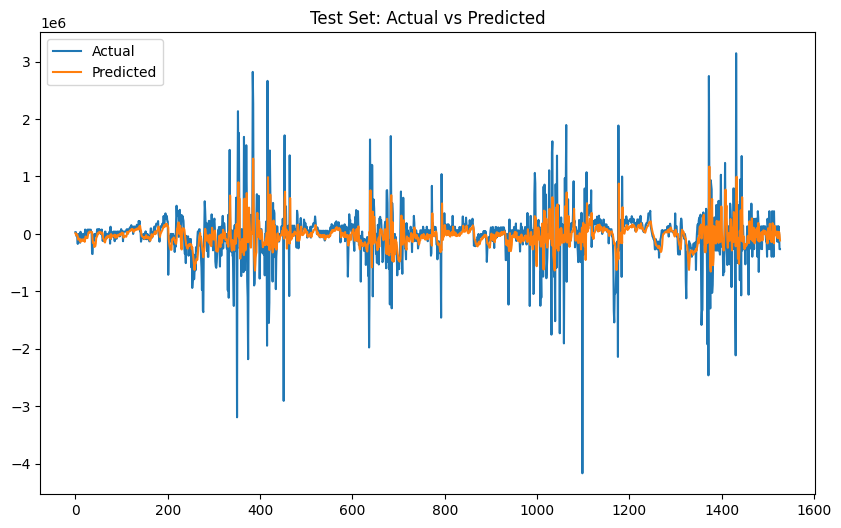

In [12]:
# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)
# Inverse scaling for predictions
train_predictions = scaler.inverse_transform(np.concatenate((train_predictions, X_train[:, -1, 1:]), axis=1))[:, 0]
test_predictions = scaler.inverse_transform(np.concatenate((test_predictions, X_test[:, -1, 1:]), axis=1))[:, 0]

# Inverse scaling for actual values
y_train_inv = scaler.inverse_transform(np.concatenate((y_train.reshape(-1, 1), X_train[:, -1, 1:]), axis=1))[:, 0]
y_test_inv = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), X_test[:, -1, 1:]), axis=1))[:, 0]

# Plotting predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test_inv, label='Actual')
plt.plot(test_predictions, label='Predicted')
plt.title('Test Set: Actual vs Predicted')
plt.legend()
plt.show()


In [13]:
model.save("Model_drawdown.h5")

In [14]:
X_train.shape, X_test.shape

((6129, 7, 3), (1527, 7, 3))

In [15]:
train_dates = list(data.index)

In [16]:
n_past = 2
n_days_for_prediction= 300

In [17]:
predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq='d').tolist()

In [18]:
prediction = model.predict(X_test[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [19]:
prediction.shape

(300, 1)

In [20]:
prediction_copies = np.repeat(prediction, data.shape[1], axis=-1)

In [21]:
y_pred_future = scaler.inverse_transform(prediction_copies)[:, 0]

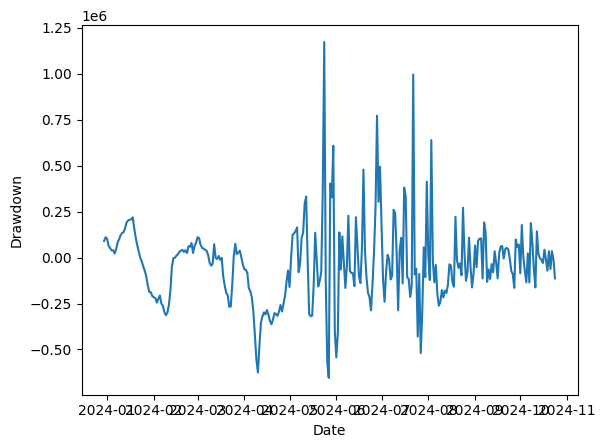

In [22]:
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Drawdown':y_pred_future})
plt = sns.lineplot(data=df_forecast, x='Date', y='Drawdown')
df_forecast.set_index('Date', inplace=True)

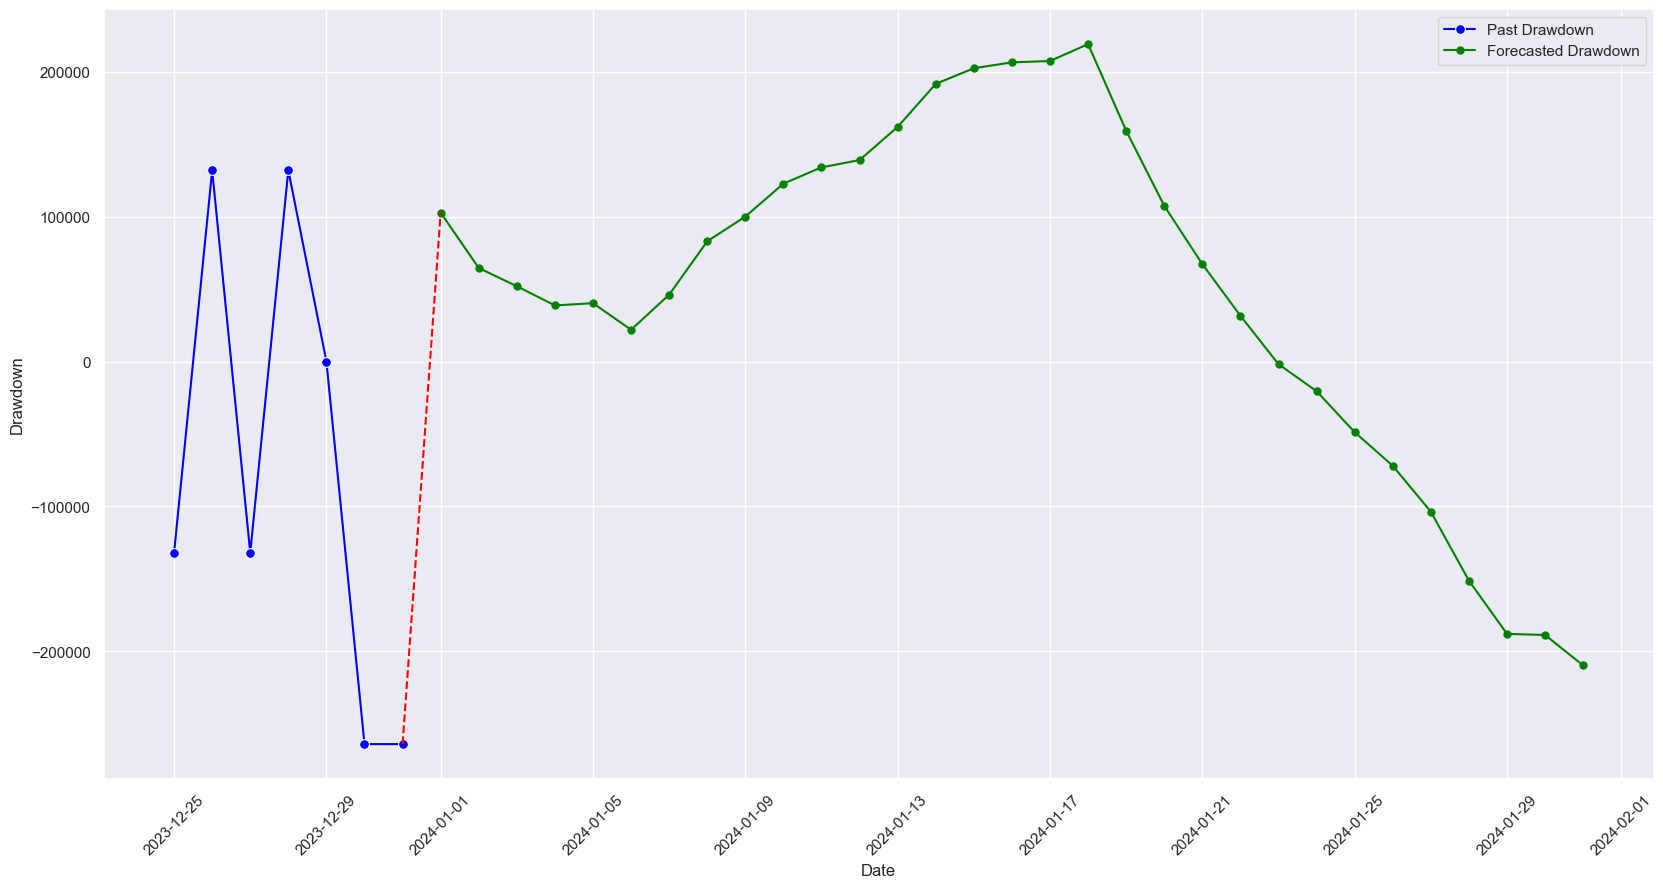

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# For the past data
original = data[['Drawdown']]
original = original.loc[(original.index >= original.index[-7]) & (original.index <= original.index[-1])]

# For the forecasted data plot
last_known_date = original.index[-1]
start_date = last_known_date + pd.Timedelta(days=1)
forecast_end_date = start_date + pd.Timedelta(days=30)
forecast_dates = pd.date_range(start=start_date, end=forecast_end_date)
forecast_values = df_forecast.loc[forecast_dates, 'Drawdown']

# Connect the past data to the forecasted data
last_known_value = original['Drawdown'].iloc[-1]

# Plotting
sns.set(rc={'figure.figsize':(20, 10)})
sns.lineplot(data=original, x=original.index, y='Drawdown', color='blue', marker='o', markersize=7, label='Past Drawdown')
plt.plot(forecast_dates, forecast_values, label='Forecasted Drawdown', color='green', marker='o', markersize=5)

# Connect past data to forecasted data
plt.plot([last_known_date, forecast_dates[0]], [last_known_value, forecast_values.iloc[0]], color='red', linestyle='--')

plt.xticks(rotation=45)
plt.legend()
plt.show()


In [24]:
# Calculate MAPE
mape = np.mean(np.abs((data - df_forecast) / data)) * 100
print(mape)

138.04211499763258


In [25]:
y_true = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), 2))), axis=1))
y_pred = scaler.inverse_transform(np.concatenate((model.predict(X_test).reshape(-1, 1), np.zeros((len(y_test), 2))), axis=1))

# Calculate MAE
mae = mean_absolute_error(y_true, y_pred)
print("Mean Absolute Error (MAE):", mae)


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Mean Absolute Error (MAE): 81623.19875977798


In [26]:
from sklearn.metrics import mean_squared_error

# Calculate MSE
mse = mean_squared_error(y_true, y_pred)

# Calculate RMSE
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)
mse

Root Mean Squared Error (RMSE): 257514.61602501696


66313777466.511925

In [27]:
from sklearn.metrics import r2_score

# Calculate R-squared
r_squared = r2_score(y_true, y_pred)
print("R-squared:", r_squared)


R-squared: 0.6867550049996103
